In [1]:
import argparse
import copy
import os
import sys

# Libs and helpers
from collections import OrderedDict

import numpy as np
import scipy.linalg
import tensorflow as tf

import c3.libraries.algorithms as algorithms
import c3.libraries.envelopes
import c3.libraries.fidelities as fidelities
import c3.utils.qt_utils as qt_utils
from c3.signal.pulse import EnvelopeDrag
from c3.utils.tf_utils import tf_project_to_comp, tf_abs, tf_unitary_overlap
import four_level_transmons.custom_gates as custom_gates
from c3.experiment import Experiment as Exp
# Main C3 objects
from c3.libraries import constants
from c3.model import Model as Mdl
from c3.optimizers.optimalcontrol import OptimalControl
from c3.parametermap import ParameterMap as PMap
from four_level_transmons.DataOutput import DataOutput
from four_level_transmons.custom_envelopes import *
from four_level_transmons.plotting import *
from four_level_transmons.utilities import *
tf.config.run_functions_eagerly(True)
np.set_printoptions(linewidth=300)

2022-06-01 17:05:21.516387: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-01 17:05:21.516414: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
if len(sys.argv[1:]) > 0 and "ipykernel_launcher" not in sys.argv[0]:
    parser = argparse.ArgumentParser()
    parser.add_argument("output", help="Output directory")
    args = parser.parse_args()
    output_dir = args.output
    print("Output directory: ", output_dir)
else:
    print("=========== WARNING: no output directory specified ============")
    output_dir = "./output"

=========== WARNING: no output directory specified ============


In [3]:
# general settings
numPWCPieces = 60
usePWC = True
useDRAG = False
t_final1 = 300e-9
t_final2 = 300e-9
sim_res = 50e9
t_final_sum = t_final1 + t_final2
awg_res = numPWCPieces / t_final1 if usePWC else 2e9

ALGORITHM_LBFGS = 0
ALGORITHM_LBFGS_GRAD_FREE = 1
ALGORITHM_CMAES = 2
ALGORITHM_GCMAES = 3
selected_algorithms = [ALGORITHM_LBFGS]

In [15]:
entanglementInitState = [0, 1]
entanglementInitStateFull = [0, 1]

def printSignal(exper: Experiment, qubits: List[chip.Qubit],
                gateSequence: List[gates.Instruction], output: DataOutput,
                states: List[Tuple[float, str]] = None):
    # generate signals
    for gateIdx, gate in enumerate(gateSequence):
        signals = exper.pmap.generator.generate_signals(gate)
        for i, qubit in enumerate(qubits):
            drive = getDrive(exper.pmap.model, qubit).name
            signal = signals[drive]
            ts = signal["ts"].numpy()
            values = signal["values"].numpy()

            # save data
            #peakFrequencies, peakValues = findFrequencyPeaks(ts, values, 4)
            #print(f"peaks: {drive}", np.sort(peakFrequencies))
            output.save([ts, values], f"signal_gate{gateIdx}_t{i + 1}")

            # plot
            plotSignalAndSpectrum(ts, real=values, filename=output.createFileName(f"signal_gate{gateIdx}_t{i + 1}", "svg"),
                                  spectralThreshold=None)
            plotSignalAndSpectrum(ts, real=values, filename=output.createFileName(f"signal_detail_gate{gateIdx}_t{i + 1}", "svg"),
                                  spectralThreshold=1e-4)
            plotSignalAndSpectrum(ts, real=values, filename=output.createFileName(f"signal_detail_with_states_gate{gateIdx}_t{i + 1}", "svg"),
                                  states=states,
                                  spectralThreshold=1e-4)


def printTimeEvolution(exper: Experiment, init: tf.Tensor, gateSequence: List[gates.Instruction],
                       labels: List[str], output: DataOutput):
    sequence = [gate.get_key() for gate in gateSequence]
    populations = calculatePopulation(exper, init, sequence)
    output.save(populations, "population")
    plotPopulation(exper, populations, sequence=sequence,
                   labels=labels, filename=output.createFileName("population", "svg"))
    plotSplittedPopulation(exper, populations, sequence, filename=output.createFileName("population", "svg"))


def stateEntropyAB(state: tf.Tensor):
    rho = densityMatrix(state)
    if state.shape[0] > 16:
        rho = tf_project_to_comp(rho, dims=[5, 5], outdims=[4, 4])
    rhoBD = tf_project_to_comp(rho, dims=[2, 2, 2, 2], outdims=[0, 2, 0, 2])
    #rhoBD = partialTrace(rho, [1, 3])
    rhoB = partialTrace(rhoBD, [0])
    #rhoAB = partialTrace(rho, [0, 1])
    return entanglementEntropy(rhoB)  #- entanglementEntropy(rhoBD)


def printEntanglementEvolution(exper: Experiment, gateSequence: List[gates.Instruction], output: DataOutput):
    sequence = [gate.get_key() for gate in gateSequence]
    entropies = []
    #for state in [(0, 1), (0, 5), (1, 6), (5, 6)]:
    for state in [(0, 1), (0, 4), (1, 5), (4, 5)]:
    #for state in [(0, 4), (5, 6), (10, 11), (12, 13)]:
        psi_init = np.zeros(shape=(model.tot_dim,))
        psi_init[state[0]] = psi_init[state[1]] = 1 / np.sqrt(2)
        entropy = calculateObservable(exper, np.array(psi_init), sequence, stateEntropyAB)
        entropies.append(entropy)
    entropies = np.array(entropies)
    plotPopulation(exper, entropies, sequence=sequence,
                   labels=["00+01", "00+10", "01+11", "10+11"],
                   filename=output.createFileName("entanglement", "svg"),
                   labelY="Entropy")


def printMatrix(M: np.array, labels: List[str], name: str, output: DataOutput):
    #plotComplexMatrix(M, xlabels=labels, ylabels=labels, filename=output.createFileName(name))
    plotComplexMatrixHinton(M, maxAbsolute=1, xlabels=labels, ylabels=labels, gridColour="gray",
                            filename=output.createFileName(name, "svg"), colourMap='hsv')
    #plotComplexMatrixAbsOrPhase(M, xlabels=labels, ylabels=labels, phase=True,
    #                            filename=output.createFileName(name + "_phase"))
    #plotComplexMatrixAbsOrPhase(M, xlabels=labels, ylabels=labels, phase=False,
    #                            filename=output.createFileName(name + "_abs"))


def printPropagator(exper: Experiment, gateSequence: List[gates.Instruction],
                    labels: List[str], output: DataOutput,
                    savePartials=False):
    fullPropagator = None
    for idx,gate in enumerate(gateSequence):
        U = exper.propagators[gate.get_key()]
        output.save(U, f"propagator_{idx}")
        #output.save(exper.partial_propagators[gate.get_key()], "partial_propagators")
        #os.system('bzip2 -9 "' + output.createFileName('partial_propagators.npy') + '"')
        printMatrix(U, labels, f"propagator_{idx}", output)
        if savePartials:
            output.save(exper.partial_propagators[gate.get_key()], f"partial_propagators_{idx}")
        if fullPropagator is None:
            fullPropagator = np.eye(U.shape[0], dtype=np.complex128)
        fullPropagator = tf.matmul(fullPropagator, U)
    printMatrix(fullPropagator, labels, "fullPropagator", output)


def printAllSignals(exper: Experiment, qubit: chip.Qubit, output: DataOutput, directory: str):
    try:
        os.mkdir(output.getDirectory() + "/" + directory)
    except:
        pass
    drive = getDrive(exper.pmap.model, qubit)
    outputs = exper.pmap.generator.global_signal_stack[drive.name]
    for name, values in outputs.items():
        filename = output.createFileName(directory + "/device_" + name, "svg")
        time = values["ts"].numpy()
        if name.startswith("LO"):
            #time = time[:100]
            re = values["inphase"].numpy()
            im = values["quadrature"].numpy()
            plotSignalAndSpectrum(time, real=re, min_signal_limit=None,
                                  spectralThreshold=5e-4,
                                  filename=output.createFileName(directory + "/device_" + name + "_real", "svg"))
            plotSignalAndSpectrum(time, real=im, min_signal_limit=None,
                                  spectralThreshold=5e-4,
                                  filename=output.createFileName(directory + "/device_" + name + "_imag", "svg"))
        elif "values" in values:
            signal = values["values"].numpy()
            plotSignalAndSpectrum(time, signal, min_signal_limit=None, filename=filename, spectralThreshold=5e-4)
        else:
            plotSignalAndSpectrum(time, real=values["inphase"].numpy(), imag=values["quadrature"].numpy(),
                                  min_signal_limit=None, spectralThreshold=5e-4, filename=filename)

'''
def entanglementStateGoal(actual: tf.constant, index, dims, active_levels):
    dim = active_levels ** len(dims)
    actual_comp = tf_project_to_comp(
        actual, dims=dims, index=index, outdims=[active_levels] * len(dims)
    )
    entropies = []
    for state in [(0, 4)]: #, (0, 1), (1, 5), (4, 5)]:
        psi_init = [[0] * dim]
        psi_init[0][state[0]] = psi_init[0][state[1]] = 1.0 / np.sqrt(2)
        init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
        #psi = np.zeros((dim, 1))
        #psi[state[0], 0] = psi[state[1], 0] = 1 / np.sqrt(2)
        #psi_init = tf.constant(psi, dtype=actual_comp.dtype)
        #init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
        psi_actual = tf.matmul(actual_comp, init_state)
        rho = densityMatrix(psi_actual)

        # S(B) - S(BD)
        rhoBD = partialTrace(rho, [1, 3])
        #entropyBD = entanglementEntropy(rhoBD)
        rhoB = partialTrace(rhoBD, [0])
        entropyB = entanglementEntropy(rhoB)
        entropies.append(entropyB)

        # S(AB)
        #rhoAB = partialTrace(rho, [0, 1])
        #entropies.append(entanglementEntropy(rhoAB) / 2)
    return 1 - np.max(entropies)
'''

def entanglementStateGoalTF(actual: tf.constant, index, dims, active_levels):
    dim = active_levels ** len(dims)
    actual_comp = tf_project_to_comp(
        actual, dims=dims, index=index, outdims=[active_levels] * len(dims)
    )

    # initial and final state
    psi = np.zeros((dim, 1))
    for i in entanglementInitState:
        psi[i, 0] = 1
    psi /= np.linalg.norm(psi)
    psi_init = tf.constant(psi, dtype=actual_comp.dtype)
    psi_actual = tf.matmul(actual_comp, psi_init)
    rho = densityMatrixTF(psi_actual[:, 0])

    # calculate entropy
    rhoBD = tf_project_to_comp(rho, dims=[2, 2, 2, 2], outdims=[0, 2, 0, 2])
    #rhoBD = partialTraceTF(rho, [1, 3])
    #entropyBD = entanglementEntropyTF(rhoBD) / 2
    rhoB = partialTraceTF(rhoBD, [0])
    entropyB = entanglementEntropyTF(rhoB)
    #return (1.0 - entropyB + entropyBD) + 0.5 * (1.0 - tf.math.real(tf.norm(psi_actual)))
    return (1.0 - entropyB) + 0.5 * (1.0 - tf.math.real(tf.norm(psi_actual)))

    #rhoAB = partialTraceTF(rho, [0, 1])
    #entropyAB = entanglementEntropyTF(rhoAB)
    #return (2.0 - entropyAB) + 0.5 * (1.0 - tf.math.real(tf.norm(psi_actual)))


def entanglementGoal(propagators: dict, instructions: dict, index, dims, active_levels=2, n_eval=-1):
    infids = []
    for gate, propagator in propagators.items():
        infid = entanglementStateGoalTF(propagator, index, dims, active_levels)
        infids.append(infid)
    return tf.reduce_mean(infids)


def optimise(output: DataOutput, qubits: List[chip.PhysicalComponent],
             exp: Experiment, algorithm, options, gateSequence: List[gates.Instruction]) -> List[float]:
    # set up the optimiser
    names: List[str] = [gate.name for gate in gateSequence]
    opt = OptimalControl(
        dir_path=output.getDirectory(),
        fid_func=fidelities.unitary_infid_sequence,
        #fid_func=entanglementGoal,
        fid_subspace=[q.name for q in qubits],
        pmap=exp.pmap,
        algorithm=algorithm,
        options=options,
        run_name=', '.join(names),
        fid_func_kwargs={
            "active_levels": 4,
            "signalFidelityCoef": 1e-12
        }
    )
    exp.set_opt_gates([gate.get_key() for gate in gateSequence])
    opt.set_exp(exp)

    # add the callback
    infidelities = []

    def fidelityCallback(index, fidelity):
        print(index, fidelity)
        infidelities.append(fidelity)

    opt.set_callback(fidelityCallback)

    # run optimisation
    opt.optimize_controls()
    print(opt.current_best_goal)
    exp.pmap.print_parameters()

    return infidelities

In [5]:
# coupling=30: f=4.6, anh=-200; f=4.32, anh=-350
# f=4.5: anh=-200, coupling=33
# Initialise the qubits and drive lines
qubit_levels = [4, 4]
qubit_frequencies = [5e9, 4.5e9]
anharmonicities = [-300e6, -250e6]
t1s = [25e-6, 25e-6]
t2stars = [35e-6, 35e-6]
qubit_temps = [50e-3, 50e-3]
couplingStrength = 30e6
print("qubits frequencies: ", qubit_frequencies, "anharmonicities: ", anharmonicities,
      "coupling: ", couplingStrength)

level_labels_transmon = ["|0,0\\rangle", "|0,1\\rangle", "|1,0\\rangle", "|1,1\\rangle"]
for i in range(len(level_labels_transmon), max(qubit_levels)):
    level_labels_transmon.append("leakage")
level_labels = []
level_labels_with_leakage = []
level_labels_short = []
for i in range(qubit_levels[0]):
    for j in range(qubit_levels[1]):
        if i > 3 or j > 3:
            level_labels_with_leakage.append("leakage")
            level_labels_short.append(None)
        else:
            s = f"${level_labels_transmon[i]},{level_labels_transmon[j]}$"
            level_labels.append(s)
            level_labels_with_leakage.append(s)
            level_labels_short.append(f"{i},{j}")
level_labels_transmon = [f"${x}$" for x in level_labels_transmon]
output = DataOutput(output_dir, file_suffix='before')

qubits = createQubits(qubit_levels, qubit_frequencies, anharmonicities,
                         t1s, t2stars, qubit_temps)
coupling = createChainCouplings([couplingStrength], qubits)
drives = createDrives(qubits)

qubits frequencies:  [5000000000.0, 4500000000.0] anharmonicities:  [-300000000.0, -250000000.0] coupling:  30000000.0


2022-06-01 17:05:24.307118: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-01 17:05:24.307138: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-01 17:05:24.307152: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2022-06-01 17:05:24.307356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Create the model
model = Mdl(qubits, coupling + drives)
model.set_lindbladian(False)
model.set_dressed(True)
model.set_FR(False)

#energies = model.get_Hamiltonian().numpy().diagonal().real / (2 * np.pi)
#print("energies: ", energies)
qubitEnergies = [q.get_Hamiltonian().numpy().diagonal().real / (2 * np.pi) for q in qubits]
qubitEnergies[0] = qubitEnergies[0][::qubit_levels[0]]
qubitEnergies[1] = qubitEnergies[1][:qubit_levels[1]]
qubitTransitions = [np.array([e[i + 1] - e[i] for i in range(len(e) - 1)]) for e in qubitEnergies]
for i in range(len(qubits)):
    print(f"Qubit {i}:")
    print(qubitEnergies[i])
    print(qubitTransitions[i])

Qubit 0:
[0.00e+00 5.00e+09 9.70e+09 1.41e+10 1.82e+10]
[5.0e+09 4.7e+09 4.4e+09 4.1e+09]
Qubit 1:
[0.000e+00 4.500e+09 8.750e+09 1.275e+10 1.650e+10]
[4.50e+09 4.25e+09 4.00e+09 3.75e+09]


In [7]:
stored_pmap_1 = PMap()
stored_pmap_1.read_config("./optimised_params/CZ_2gates_d.json")
stored_params_1 = stored_pmap_1.asdict()["cz_t1_t2[0, 1]"]

stored_pmap_2 = PMap()
stored_pmap_2.read_config("./optimised_params/CZ_2gates_d.json")
stored_params_2 = stored_pmap_2.asdict()["phase_correction[0, 1]"]

In [8]:
# Create the generator
generator = createGenerator2LOs(drives, sim_res=sim_res, awg_res=awg_res)

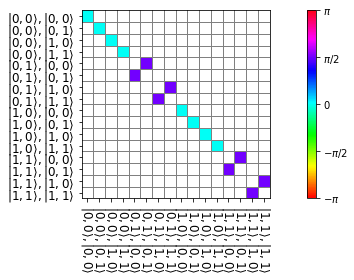

In [9]:
ideal_gate = custom_gates.GATE_CZ_t1q2_t2q2
#ideal_gate_Unity = qt_utils.np_kron_n([constants.Id, constants.Id])
#ideal_gate2 = qt_utils.np_kron_n([ideal_gate_Unity, ideal_gate_Unity])
printMatrix(ideal_gate, level_labels, "ideal_gate", output)

gateA = gates.Instruction(
    name="cz_t1_t2",
    #name="unity",
    targets=[0, 1],
    t_start=0.0,
    t_end=t_final1,
    channels=[d.name for d in drives],
    ideal=ideal_gate,
)
gateB = gates.Instruction(
    name="phase_correction",
    #name="unity",
    targets=[0, 1],
    t_start=0.0,
    t_end=t_final2,
    channels=[d.name for d in drives],
    ideal=ideal_gate,
)
gateSequence = [gateA, gateB]

In [10]:
# Envelopes and carriers
'''
carrier_freqs = [
    #[0.5*(qubitTransitions[0][1]+qubitTransitions[0][0]), 0.5*(qubitTransitions[0][2]+qubitTransitions[0][1])],
    [qubitTransitions[0][0], qubitTransitions[0][2]],
    #[qubitTransitions[1][0]],
    #[0.5*(qubitTransitions[1][1]+qubitTransitions[1][0]), 0.5*(qubitTransitions[1][2]+qubitTransitions[1][1])],
    [qubitTransitions[1][0], qubitTransitions[1][2]]
    #[qubitTransitions[1][0]]
]
df = couplingStrength ** 2 / (qubit_frequencies[0] - qubit_frequencies[1])
print("shift: ", df)
carrier_freqs[0] = [x + df for x in carrier_freqs[0]]
carrier_freqs[1] = [x - df for x in carrier_freqs[1]]

carrier_framechange = [
    [0.01, 0.01],
    [0.01, 0.01]
]
pulse_t_final = [
    [t_final, t_final],
    [t_final, t_final]
]
pulse_sigmas = [
    [t_final/5, t_final/5],
    [t_final/5, t_final/5]
]
pulse_amps = [
    [0.1, 0.1],
    [0.1, 0.1]
]
pulse_deltas = [
    [0.01, 0.01],
    [0.01, 0.01]
]
pulse_xy_angles = [
    [0.01, 0.01],
    [0.01, 0.01]
]
pulse_freq_offsets = [
    [0.01, 0.01],
    [0.01, 0.01]
]
'''

envelopes = []
envelopesForDrive = {g.name: {d.name: [] for d in drives} for g in gateSequence}
carriers = []
carriersForDrive = {g.name: {d.name: [] for d in drives} for g in gateSequence}

# copy carriers and envelopes from file
for gate, stored_params, t_final in zip(gateSequence, [stored_params_1, stored_params_2], [t_final1, t_final2]):
    for idx in [0, 1]:
        dstIdx = idx
        srcIdx = idx
        driveNameSrc = drives[srcIdx].name
        driveNameDst = drives[dstIdx].name
        stored_params_d = stored_params["drive_channels"][driveNameSrc]
        for i in range(2):
            env: pulse.Envelope = copy.deepcopy(stored_params_d[f"envelope_{driveNameSrc}_{i + 1}"])
            if useDRAG and not isinstance(env, EnvelopeDrag):
                env = convertToDRAG(env)
            if usePWC:
                if env.shape != c3.libraries.envelopes.pwc:
                    env = convertToPWC(env, numPWCPieces)
                elif len(env.params["inphase"]) != numPWCPieces:
                    env = resamplePWC(env, numPWCPieces)
            env.name = f"envelope_{driveNameDst}_{i + 1}"
            env = scaleGaussianEnvelope(env, t_final / env.params['t_final'].get_value())
            envelopes.append(env)
            envelopesForDrive[gate.name][driveNameDst].append(env)
            gate.add_component(copy.deepcopy(env), driveNameDst)

            carrier = copy.deepcopy(stored_params_d[f"carrier_{driveNameSrc}_{i + 1}"])
            carrier.name = f"carrier_{driveNameDst}_{i + 1}"
            if idx == 1:
                carrier.params["framechange"].set_value(15 * 2 * np.pi % (2 * np.pi))
            carriers.append(carrier)
            carriersForDrive[gate.name][driveNameDst].append(carrier)
            gate.add_component(copy.deepcopy(carrier), driveNameDst)

# create carriers and envelopes
'''
for idx in []:
    for i in range(0, len(carrier_freqs[idx])):
        env = createGaussianPulse(
            t_final=pulse_t_final[idx][i],
            sigma=pulse_sigmas[idx][i],
            amp=pulse_amps[idx][i],
            delta=pulse_deltas[idx][i],
            xy_angle=pulse_xy_angles[idx][i],
            freq_off=pulse_freq_offsets[idx][i],
            useDrag=useDRAG
        )
        #env = createNoDriveEnvelope(t_final)
        if usePWC:
            env = convertToPWC(env, numPWCPieces)
        env.name = f"envelope_{drives[idx].name}_{i + 1}"
        envelopes.append(env)
        envelopesForDrive[drives[idx].name].append(env)

        carrier_parameters = {
            "freq": Qty(value=carrier_freqs[idx][i], min_val=0.98 * carrier_freqs[idx][i],
                        max_val=1.02 * carrier_freqs[idx][i], unit="Hz 2pi"),
            "framechange": Qty(value=carrier_framechange[idx][i], min_val=-np.pi, max_val=3 * np.pi, unit="rad"),
        }
        carrier = pulse.Carrier(
            name=f"carrier_{drives[idx].name}_{i + 1}",
            desc="Frequency of the local oscillator",
            params=carrier_parameters,
        )
        carriers.append(carrier)
        carriersForDrive[drives[idx].name].append(carrier)
'''

for gate in gateSequence:
    print(f"Gate {gate.name}:")
    print("carrier: ", [[carrier.params["freq"] for carrier in carriers] for carriers in carriersForDrive[gate.name].values()])
    print("amp: ", [[env.params["amp"] for env in envelopes] for envelopes in envelopesForDrive[gate.name].values()])

Gate iCNOT_A:
carrier:  [[4.999 GHz 2pi, 4.400 GHz 2pi], [4.498 GHz 2pi, 3.996 GHz 2pi]]
amp:  [[18.279 mV, 9.750 mV], [666.088 µV, 664.929 µV]]
Gate iCNOT_B:
carrier:  [[5.096 GHz 2pi, 4.313 GHz 2pi], [4.415 GHz 2pi, 4.079 GHz 2pi]]
amp:  [[300.004 mV, 299.995 mV], [299.998 mV, 300.002 mV]]


In [11]:
# all energy levels with labels
stateEnergies = []
H = model.get_Hamiltonian().numpy()
evals,evecs = scipy.linalg.eig(H)
evals = evals.real / (2 * np.pi)
indices = [np.argmax(np.round(evecs[i], 2)) for i in range(len(evals))]
for i, x in enumerate(level_labels_short):
    if level_labels_short[i] is not None:
        energy = evals[indices[i]]
        stateEnergies.append((energy, x))

# all energy transitions
items = sorted(stateEnergies, key=lambda x: x[0])
transitions = []
for i in range(len(items)):
    for j in range(len(items)):
        if i != j:
            #print(i, j)
            E = items[j][0] - items[i][0]
            if E > 0:
                transitions.append((E, items[i][1] + " - " + items[j][1]))

#for t in transitions:
#    print(t)

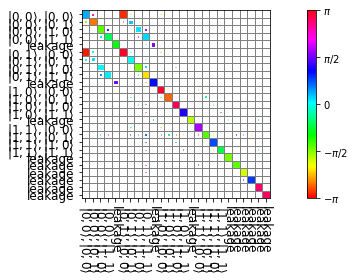

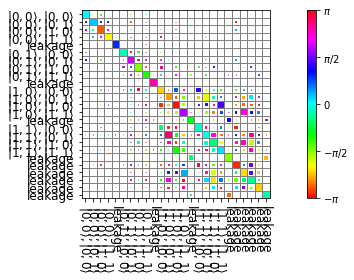

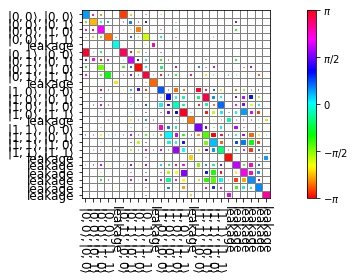

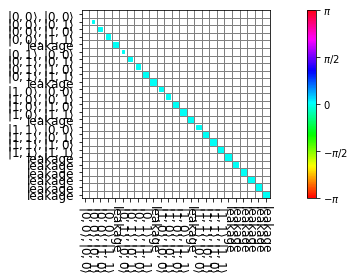

In [16]:
# Set up the experiment
parameter_map = PMap(instructions=gateSequence, model=model, generator=generator)
exp = Exp(pmap=parameter_map, sim_res=sim_res)
exp.set_opt_gates([gate.get_key() for gate in gateSequence])

unitaries = exp.compute_propagators()
printPropagator(exp, gateSequence, level_labels_with_leakage, output)
#printAllSignals(exp, qubit, output, directory="devices_before")
printMatrix(model.get_Hamiltonian() / np.max(model.get_Hamiltonian()), level_labels_with_leakage, 'Hamiltonian', output)
printSignal(exp, qubits, gateSequence, output=output, states=transitions)

initial state:  [[0.70710678 0.70710678 0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]]


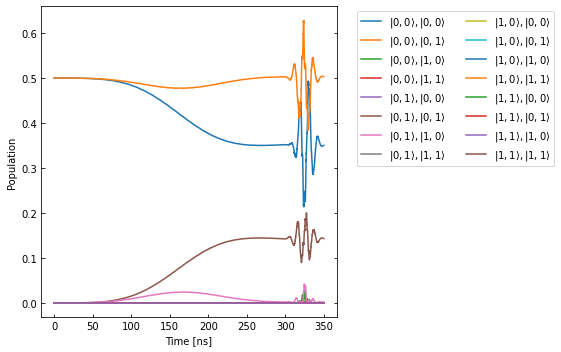

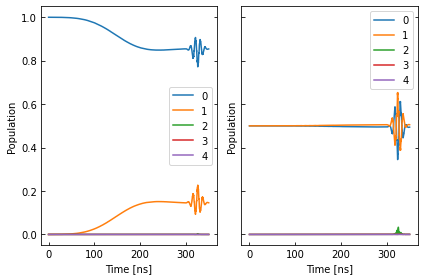

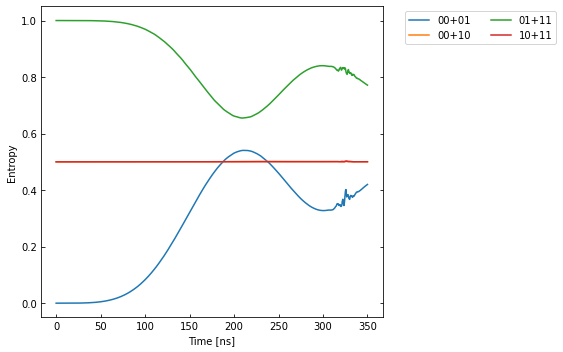

In [17]:
# Specify the initial state
psi_init = [[0] * model.tot_dim]
for i in entanglementInitStateFull:
    psi_init[0][i] = 1
psi_init /= np.linalg.norm(psi_init)
print("initial state: ", psi_init)
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = [gate.get_key() for gate in gateSequence]

printTimeEvolution(exp, init_state, gateSequence, level_labels, output)
printEntanglementEvolution(exp, gateSequence, output)
parameter_map.write_config(output.createFileName("parameter_map", "json"))

In [19]:
# Specify the parameters to be optimised and initialise the optimiser
opt_map = []
for gate in gateSequence:
    for drive in drives:
        for env in envelopesForDrive[gate.name][drive.name]:
            opt_map.append([(gate.get_key(), drive.name, env.name, "amp")])
            opt_map.append([(gate.get_key(), drive.name, env.name, "freq_offset")])
            opt_map.append([(gate.get_key(), drive.name, env.name, "xy_angle")])
            if useDRAG:
                opt_map.append([(gate.get_key(), drive.name, env.name, "delta")])
            if usePWC:
                opt_map.append([(gate.get_key(), drive.name, env.name, "inphase")])
                opt_map.append([(gate.get_key(), drive.name, env.name, "quadrature")])
                #opt_map.append([(gate.get_key(), drive.name, env.name, "t_bin_end")])
            else:
                opt_map.append([(gate.get_key(), drive.name, env.name, "sigma")])
                opt_map.append([(gate.get_key(), drive.name, env.name, "t_final")])
        for carrier in carriersForDrive[gate.name][drive.name]:
            #opt_map.append([(gate.get_key(), drive.name, carrier.name, "freq")])
            opt_map.append([(gate.get_key(), drive.name, carrier.name, "framechange")])
parameter_map.set_opt_map(opt_map)
parameter_map.print_parameters()

iCNOT_A[0, 1]-d1-envelope_d1_1-amp    : 18.279 mV 
iCNOT_A[0, 1]-d1-envelope_d1_1-freq_offset: 500.000 KHz 2pi 
iCNOT_A[0, 1]-d1-envelope_d1_1-xy_angle: 93.221 mrad 
iCNOT_A[0, 1]-d1-envelope_d1_1-delta  : 939.448 µ 
iCNOT_A[0, 1]-d1-envelope_d1_1-sigma  : 72.485 ns 
iCNOT_A[0, 1]-d1-envelope_d1_1-t_final: 300.000 ns 
iCNOT_A[0, 1]-d1-envelope_d1_2-amp    : 9.750 mV 
iCNOT_A[0, 1]-d1-envelope_d1_2-freq_offset: 500.000 KHz 2pi 
iCNOT_A[0, 1]-d1-envelope_d1_2-xy_angle: -36.872 mrad 
iCNOT_A[0, 1]-d1-envelope_d1_2-delta  : -480.039 µ 
iCNOT_A[0, 1]-d1-envelope_d1_2-sigma  : 73.845 ns 
iCNOT_A[0, 1]-d1-envelope_d1_2-t_final: 300.000 ns 
iCNOT_A[0, 1]-d1-carrier_d1_1-freq    : 4.999 GHz 2pi 
iCNOT_A[0, 1]-d1-carrier_d1_2-freq    : 4.400 GHz 2pi 
iCNOT_A[0, 1]-d2-envelope_d2_1-amp    : 666.088 µV 
iCNOT_A[0, 1]-d2-envelope_d2_1-freq_offset: 10.000 mHz 2pi 
iCNOT_A[0, 1]-d2-envelope_d2_1-xy_angle: 9.983 mrad 
iCNOT_A[0, 1]-d2-envelope_d2_1-delta  : 10.201 m 
iCNOT_A[0, 1]-d2-envelope_d2_1-sig

In [ ]:
infidelities = []

for algorithm in selected_algorithms:
    if algorithm == ALGORITHM_LBFGS:
        infidelities = optimise(output, qubits, exp, algorithms.lbfgs, {
            "maxfun": 2000,
            "ftol": 1e-6
        }, gateSequence)
    elif algorithm == ALGORITHM_LBFGS_GRAD_FREE:
        infidelities = optimise(output, qubits, exp, algorithms.lbfgs_grad_free, {
            "maxfun": 500,
            "gtol": 1e-4,
            "ftol": 1e-4
        }, gateSequence)
    elif algorithm == ALGORITHM_CMAES:
        infidelities = optimise(output, qubits, exp, algorithms.cmaes, {
            "popsize": 15,
            "spread": 0.02,
            "maxfevals": 2000,
            "init_point": "True",
            "stop_at_sigma": 1e-3,
            "stop_at_convergence": 20
        }, gateSequence)
    elif algorithm == ALGORITHM_GCMAES:
        infidelities = optimise(output, qubits, exp, algorithms.gcmaes, {
            "cmaes": {"popsize": 12, "spread": 0.05, "maxfevals": 20,
                      "init_point": "True", "stop_at_sigma": 1e-4, "stop_at_convergence": 20},
            "lbfgs": {"maxfun": 500, "ftol": 1e-6}
        }, gateSequence)
    else:
        print("Unknown algorithm: ", algorithm)

C3:STATUS:Saving as: /home/user/c3/output/iCNOT_A, iCNOT_B/2022_06_01_T_17_16_18/open_loop.c3log


In [ ]:
# Plot results
output = DataOutput(output_dir, file_suffix='after')
plotData(np.arange(len(infidelities)), infidelities, xlabel="Step",
         ylabel="Infidelity", filename=output.createFileName("convergence", "svg"))
printSignal(exp, qubits, gateSequence, output=output, states=transitions)
#printAllSignals(exp, qubits, output, directory="devices_after")
printPropagator(exp, gateSequence, level_labels_with_leakage, output, savePartials=False)
printTimeEvolution(exp, init_state, gateSequence, level_labels, output)
printEntanglementEvolution(exp, gateSequence, output)
parameter_map.write_config(output.createFileName("parameter_map", "json"))